# Overview
The kernel shows how to use the [tf_pose_estimation](https://github.com/ildoonet/tf-pose-estimation) package in Python on a series of running videos.

## Libraries we need
Install tf_pose and pycocotools

In [142]:
!pip install -qq git+https://www.github.com/ildoonet/tf-pose-estimation

In [143]:
!pip install -qq pycocotools

In [144]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
%matplotlib inline
import tf_pose
import cv2
from glob import glob
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
import os
def video_gen(in_path):
    c_cap = cv2.VideoCapture(in_path)
    while c_cap.isOpened():
        ret, frame = c_cap.read()
        if not ret:
            break
        yield c_cap.get(cv2.CAP_PROP_POS_MSEC), frame[:, :, ::-1]
    c_cap.release()

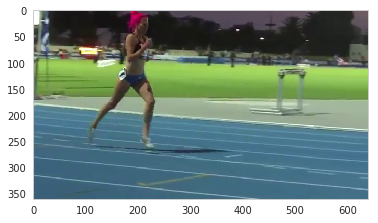

In [146]:
video_paths = glob('../input/*.mp4')
c_video = video_gen(video_paths[0])
for _ in range(300):
    c_ts, c_frame = next(c_video)
plt.imshow(c_frame)

In [147]:
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
tfpe = tf_pose.get_estimator()

In [148]:
humans = tfpe.inference(npimg=c_frame, upsample_size=4.0)
print(humans)

[BodyPart:1-(0.31, 0.15) score=0.64 BodyPart:2-(0.29, 0.14) score=0.71 BodyPart:3-(0.29, 0.24) score=0.80 BodyPart:4-(0.34, 0.18) score=0.81 BodyPart:5-(0.34, 0.15) score=0.58 BodyPart:8-(0.28, 0.35) score=0.69 BodyPart:9-(0.24, 0.49) score=0.77 BodyPart:10-(0.19, 0.59) score=0.69 BodyPart:11-(0.32, 0.36) score=0.74 BodyPart:12-(0.35, 0.48) score=0.75 BodyPart:13-(0.33, 0.66) score=0.72 BodyPart:16-(0.32, 0.08) score=0.32]


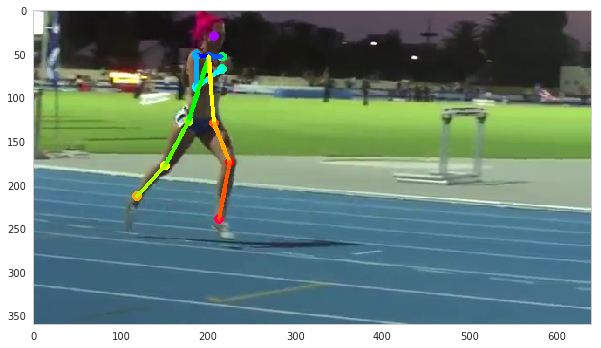

In [149]:
new_image = TfPoseEstimator.draw_humans(c_frame[:, :, ::-1], humans, imgcopy=False)
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(new_image[:, :, ::-1])

In [150]:
body_to_dict = lambda c_fig: {'bp_{}_{}'.format(k, vec_name): vec_val 
                              for k, part_vec in c_fig.body_parts.items() 
                              for vec_name, vec_val in zip(['x', 'y', 'score'],
                                                           (part_vec.x, 1-part_vec.y, part_vec.score))}
c_fig = humans[0]
body_to_dict(c_fig)

{'bp_1_x': 0.3148148148148148,
 'bp_1_y': 0.8532608695652174,
 'bp_1_score': 0.6405246257781982,
 'bp_2_x': 0.2916666666666667,
 'bp_2_y': 0.8586956521739131,
 'bp_2_score': 0.7088668942451477,
 'bp_3_x': 0.2916666666666667,
 'bp_3_y': 0.7554347826086957,
 'bp_3_score': 0.8028572797775269,
 'bp_4_x': 0.33796296296296297,
 'bp_4_y': 0.8152173913043479,
 'bp_4_score': 0.8131267428398132,
 'bp_5_x': 0.33796296296296297,
 'bp_5_y': 0.8532608695652174,
 'bp_5_score': 0.5807031393051147,
 'bp_8_x': 0.2777777777777778,
 'bp_8_y': 0.6467391304347826,
 'bp_8_score': 0.6949383616447449,
 'bp_9_x': 0.2361111111111111,
 'bp_9_y': 0.5054347826086957,
 'bp_9_score': 0.7722169160842896,
 'bp_10_x': 0.18518518518518517,
 'bp_10_y': 0.40760869565217395,
 'bp_10_score': 0.688654363155365,
 'bp_11_x': 0.32407407407407407,
 'bp_11_y': 0.6413043478260869,
 'bp_11_score': 0.7420535683631897,
 'bp_12_x': 0.35185185185185186,
 'bp_12_y': 0.5163043478260869,
 'bp_12_score': 0.7524068355560303,
 'bp_13_x': 0.33

In [ ]:
MAX_FRAMES = 200
body_pose_list = []
for vid_path in tqdm_notebook(video_paths, desc='Files'):
    c_video = video_gen(vid_path)
    c_ts, c_frame = next(c_video)
    out_path = '{}_out.avi'.format(os.path.split(vid_path)[1])
    out = cv2.VideoWriter(out_path,
                          cv2.VideoWriter_fourcc('M','J','P','G'),
                          10, 
                          (c_frame.shape[1], c_frame.shape[0]))
    for (c_ts, c_frame), _ in zip(c_video, 
                                  tqdm_notebook(range(MAX_FRAMES), desc='Frames')):
        bgr_frame = c_frame[:,:,::-1]
        humans = tfpe.inference(npimg=bgr_frame, upsample_size=4.0)
        for c_body in humans:
            body_pose_list += [dict(video=out_path, time=c_ts, **body_to_dict(c_body))]
        new_image = TfPoseEstimator.draw_humans(bgr_frame, humans, imgcopy=False)
        out.write(new_image)
    out.release()


In [152]:
import pandas as pd
body_pose_df = pd.DataFrame(body_pose_list)
body_pose_df.describe()

,bp_0_score,bp_0_x,bp_0_y,bp_10_score,bp_10_x,bp_10_y,bp_11_score,bp_11_x,bp_11_y,bp_12_score,bp_12_x,bp_12_y,bp_13_score,bp_13_x,bp_13_y,bp_14_score,bp_14_x,bp_14_y,bp_15_score,bp_15_x,bp_15_y,bp_16_score,bp_16_x,bp_16_y,bp_17_score,bp_17_x,bp_17_y,bp_1_score,bp_1_x,bp_1_y,bp_2_score,bp_2_x,bp_2_y,bp_3_score,bp_3_x,bp_3_y,bp_4_score,bp_4_x,bp_4_y,bp_5_score,bp_5_x,bp_5_y,bp_6_score,bp_6_x,bp_6_y,bp_7_score,bp_7_x,bp_7_y,bp_8_score,bp_8_x,bp_8_y,bp_9_score,bp_9_x,bp_9_y,time
count,395.000000,395.000000,395.000000,401.000000,401.000000,401.000000,410.000000,410.000000,410.000000,409.000000,409.000000,409.000000,408.000000,408.000000,408.000000,193.000000,193.000000,193.000000,375.000000,375.000000,375.000000,189.000000,189.000000,189.000000,362.000000,362.000000,362.000000,410.000000,410.000000,410.000000,384.000000,384.000000,384.000000,337.000000,337.000000,337.000000,322.000000,322.000000,322.000000,398.000000,398.000000,398.000000,388.000000,388.000000,388.000000,371.000000,371.000000,371.000000,410.000000,410.000000,410.000000,407.000000,407.000000,407.000000,421.000000
mean,0.636136,0.454665,0.848308,0.541022,0.502944,0.395072,0.638679,0.490436,0.638242,0.749054,0.467966,0.489742,0.589613,0.491580,0.386362,0.426486,0.417746,0.812204,0.633211,0.459111,0.865188,0.341873,0.406820,0.801472,0.610920,0.479486,0.872012,0.690674,0.480691,0.807105,0.648970,0.462119,0.801772,0.581955,0.451547,0.718827,0.600904,0.443510,0.709577,0.730000,0.489508,0.809482,0.656953,0.509975,0.749034,0.619963,0.483278,0.711781,0.591181,0.475666,0.640231,0.684473,0.471358,0.490092,3371.946951
std,0.237759,0.047305,0.067789,0.179964,0.122138,0.107470,0.123970,0.071088,0.032826,0.118123,0.067956,0.083083,0.157453,0.107405,0.115037,0.186953,0.046045,0.064869,0.244623,0.045306,0.069552,0.151853,0.045715,0.058662,0.303237,0.052762,0.076002,0.128189,0.073052,0.061350,0.136557,0.078053,0.059284,0.203444,0.094571,0.037930,0.217571,0.069839,0.042512,0.086096,0.065018,0.064887,0.191472,0.077784,0.050803,0.191757,0.061776,0.044139,0.162651,0.081084,0.032625,0.155117,0.083072,0.080931,1924.306561
min,0.096199,0.319444,0.663043,0.080362,0.282407,0.201087,0.159527,0.314815,0.565217,0.142920,0.300926,0.358696,0.068489,0.287037,0.195652,0.113799,0.314815,0.668478,0.107454,0.324074,0.668478,0.104609,0.305556,0.673913,0.105316,0.324074,0.673913,0.148178,0.310185,0.646739,0.228330,0.291667,0.646739,0.088015,0.273148,0.608696,0.088501,0.277778,0.608696,0.182470,0.324074,0.652174,0.064013,0.328704,0.619565,0.112935,0.328704,0.614130,0.164659,0.291667,0.565217,0.117133,0.296296,0.375000,33.366667
25%,0.464283,0.430556,0.790761,0.437960,0.416667,0.293478,0.545856,0.444444,0.619565,0.708870,0.435185,0.407609,0.526982,0.424769,0.266304,0.254299,0.407407,0.760870,0.440278,0.439815,0.809783,0.216105,0.398148,0.755435,0.264458,0.439815,0.811141,0.598869,0.430556,0.755435,0.543001,0.402778,0.755435,0.447976,0.384259,0.695652,0.452761,0.402778,0.684783,0.690120,0.450231,0.756793,0.580126,0.462963,0.711957,0.474517,0.449074,0.684783,0.447096,0.412037,0.619565,0.631551,0.414352,0.413043,1707.352846
50%,0.737223,0.476852,0.880435,0.594952,0.449074,0.423913,0.653807,0.527778,0.635870,0.767691,0.453704,0.483696,0.626025,0.446759,0.423913,0.428989,0.425926,0.804348,0.728983,0.481481,0.896739,0.317248,0.416667,0.793478,0.786232,0.513889,0.913043,0.695047,0.527778,0.831522,0.638383,0.439815,0.831522,0.624414,0.407407,0.717391,0.653049,0.430556,0.711957,0.736401,0.479167,0.831522,0.709023,0.504630,0.755435,0.687518,0.472222,0.711957,0.559080,0.523148,0.635870,0.727543,0.458333,0.489130,3381.228184
75%,0.835357,0.490741,0.902174,0.672538,0.629630,0.472826,0.734728,0.546296,0.652174,0.821888,0.490741,0.559783,0.703104,0.565972,0.472826,0.573414,0.439815,0.875000,0.835172,0.490741,0.918478,0.463152,0.425926,0.858696,0.876121,0.518519,0.929348,0.789806,0.537037,0.858696,0.757838,0.532407,0.847826,0.742964,0.532407,0.744565,0.777597,0.486111,0.733696,0.783173,0.541667,0.864130,0.785623,0.578704,

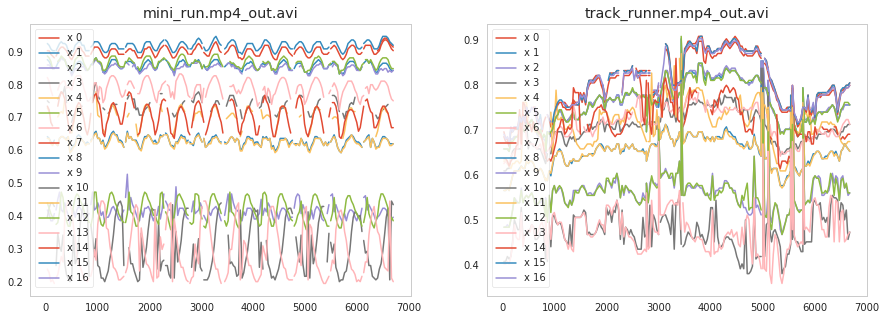

In [153]:
fig, m_axs = plt.subplots(1, 2, figsize=(15, 5))
for c_ax, (c_name, c_rows) in zip(m_axs, body_pose_df.groupby('video')):
    for i in range(17):
        c_ax.plot(c_rows['time'], c_rows['bp_{}_y'.format(i)], label='x {}'.format(i))
    c_ax.legend()
    c_ax.set_title(c_name)

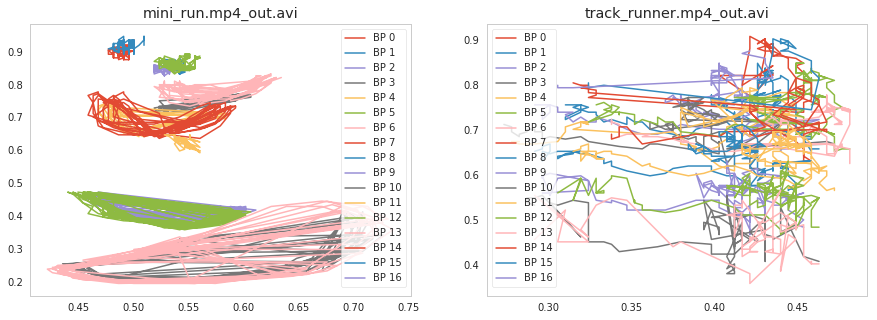

In [154]:
fig, m_axs = plt.subplots(1, 2, figsize=(15, 5))
for c_ax, (c_name, n_rows) in zip(m_axs, body_pose_df.groupby('video')):
    for i in range(17):
        c_rows = n_rows.query('bp_{}_score>0.6'.format(i)) # only keep confident results
        c_ax.plot(c_rows['bp_{}_x'.format(i)], c_rows['bp_{}_y'.format(i)], label='BP {}'.format(i))
    c_ax.legend()
    c_ax.set_title(c_name)

In [155]:
body_pose_df.to_csv('body_pose.csv', index=False)